In [ ]:
pip install emukit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import GPy
import emukit.multi_fidelity
import emukit.test_functions
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
%matplotlib inline

In [ ]:
pip install GPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
#DNS_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/LinewssDNS.csv') 
#RANS_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/LinewssRANS.csv') 
DNS_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Linewssdns_short.csv') 
RANS_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Linewssfullrans_short.csv') 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Generate sample data

x_train_l =  np.array([[70,100],[70,80],[70,50],[70,30],[70,0],[60,100],[60,80],[60,50],[60,30],[60,0],[50,100],[50,80],[50,50],[50,30],[50,0],[40,100],[40,80],[40,50],[40,30],[40,0]])
x_train_h = np.array([[70,100],[70,0],[60,80],[50,50],[40,100],[40,0]])

DNS_full=DNS_data.dropna(axis=1)
DNS_full=DNS_full.values
DNS=DNS_full[:,[0,2,3,7,8,10]]

DNS_test=DNS_full[:,[1,4,5,6,9]]
RANS=RANS_data.dropna(axis=1)
RANS_full=RANS.values
RANS_test=RANS_full[:,[0,1,3,4,5,6,7,10,12,13,14,15,16,17,19]]
RANS=RANS_full
#D_70_100=np.array(DNS_data['70_100'])
#D_70_100=D_70_100.reshape(-1,1)
#np.stack(())
#print(column_values.shape)

DNS_full=np.transpose(DNS_full)
y_train_h=np.transpose(DNS)
y_train_l=np.transpose(RANS)

In [ ]:
# x_train_l=np.c_[ x_train_l, np.zeros(len(x_train_l)) ]   
# x_train_h=np.c_[ x_train_h, np.ones(len(x_train_h)) ]   
# X_train=np.append(x_train_l,x_train_h,axis=0)
# 
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

Y_train=np.append(y_train_l,y_train_h,axis=0)
X_train, Y_train = convert_xy_lists_to_arrays([x_train_h, x_train_l], [y_train_h, y_train_l])
print(X_train.shape)
print(Y_train.shape)

print(X_train)

(26, 3)
(26, 57)
[[ 70. 100.   0.]
 [ 70.   0.   0.]
 [ 60.  80.   0.]
 [ 50.  50.   0.]
 [ 40. 100.   0.]
 [ 40.   0.   0.]
 [ 70. 100.   1.]
 [ 70.  80.   1.]
 [ 70.  50.   1.]
 [ 70.  30.   1.]
 [ 70.   0.   1.]
 [ 60. 100.   1.]
 [ 60.  80.   1.]
 [ 60.  50.   1.]
 [ 60.  30.   1.]
 [ 60.   0.   1.]
 [ 50. 100.   1.]
 [ 50.  80.   1.]
 [ 50.  50.   1.]
 [ 50.  30.   1.]
 [ 50.   0.   1.]
 [ 40. 100.   1.]
 [ 40.  80.   1.]
 [ 40.  50.   1.]
 [ 40.  30.   1.]
 [ 40.   0.   1.]]


In [ ]:
## Create standard GP model using only high-fidelity data
x_train_DNS=x_train_h
y_train_DNS=y_train_h
# Define the kernel function for the output dimensions
kernel_output = GPy.kern.ExpQuad(input_dim=57,lengthscale=5.0,variance=0.0001)

# Compute the kernel matrix for the output dimensions using the training data
K = kernel_output.K(y_train_DNS)
kernelDNS = GPy.kern.ExpQuad(input_dim=2,lengthscale=5.0,variance=0.0001)
high_gp_model = GPy.models.GPRegression(x_train_DNS, y_train_DNS, kernelDNS,noise_var=0.0001)


# Set the precomputed kernel matrix for the output dimensions
high_gp_model.posterior._K = K
## Fit the GP model

high_gp_model.optimize_restarts(500)


Optimization restart 1/500, f = 1220.1684898870694
Optimization restart 2/500, f = 1331.7972144201253
Optimization restart 3/500, f = 1331.7972144208636
Optimization restart 4/500, f = 1331.7972144183832
Optimization restart 5/500, f = 1331.7972144209848
Optimization restart 6/500, f = 1331.797214418384
Optimization restart 7/500, f = 1331.7972144183832
Optimization restart 8/500, f = 1331.7972144221305
Optimization restart 9/500, f = 1331.7972144183827
Optimization restart 10/500, f = 1331.7972144183834
Optimization restart 11/500, f = 1331.797214420768
Optimization restart 12/500, f = 1331.7972144189478
Optimization restart 13/500, f = 1331.7972144184841
Optimization restart 14/500, f = 1331.7972144206356
Optimization restart 15/500, f = 1331.797214418631
Optimization restart 16/500, f = 1331.797214418804
Optimization restart 17/500, f = 1331.7972144183834
Optimization restart 18/500, f = 1331.797214419375
Optimization restart 19/500, f = 1331.7972144183886
Optimization restart 20/50

In [ ]:
## Create standard GP model using only low-fidelity data

x_train_RANS= np.array([[70,100],[70,80],[70,30],[70,0],[60,100],[60,80],[60,50],[50,100],[50,50],[50,30],[50,0],[40,100],[40,80],[40,50],[40,0]])

y_train_RANS=np.transpose(RANS_test)
print(y_train_RANS.shape)
kernel_outputRANS = GPy.kern.ExpQuad(input_dim=57,lengthscale=5.0,variance=0.0001)

# Compute the kernel matrix for the output dimensions using the training data
KRANS = kernel_outputRANS.K(y_train_RANS)

(15, 57)


In [ ]:
kernelRANS = GPy.kern.ExpQuad(input_dim=2,lengthscale=10.0)
low_gp_model = GPy.models.GPRegression(x_train_RANS, y_train_RANS, kernelRANS)


## Fit the GP model
low_gp_model.posterior._K = K
low_gp_model.optimize_restarts(500)

Optimization restart 1/500, f = 2194.2443506873533
Optimization restart 2/500, f = 3189.6572114140918
Optimization restart 3/500, f = 3189.657211414089
Optimization restart 4/500, f = 3189.6572114141354
Optimization restart 5/500, f = 3189.657211415123
Optimization restart 6/500, f = 3189.657211414089
Optimization restart 7/500, f = 3189.6572114141554
Optimization restart 8/500, f = 3189.6572114141327
Optimization restart 9/500, f = 3189.657211414106
Optimization restart 10/500, f = 3189.657211414095
Optimization restart 11/500, f = 3189.6572114142805
Optimization restart 12/500, f = 3189.657207754241
Optimization restart 13/500, f = 3189.6572114140895
Optimization restart 14/500, f = 3189.6572114140913
Optimization restart 15/500, f = 3189.657211414089
Optimization restart 16/500, f = 3189.6572114140895
Optimization restart 17/500, f = 3189.65721141455
Optimization restart 18/500, f = 3189.6572114146716
Optimization restart 19/500, f = 3189.657211150633
Optimization restart 20/500, f 

In [ ]:

kernels = [GPy.kern.ExpQuad(input_dim=2,lengthscale=5.0,variance=0.0001),GPy.kern.ExpQuad(input_dim=2,lengthscale=5.0,variance=0.0001)]
kernelMFO=[GPy.kern.ExpQuad(input_dim=57,lengthscale=5.0,variance=0.0001)]
lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)

gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2)

gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0.0001)

gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0.0001)
lin_mf_model =model=GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=5)

## Fit the model

lin_mf_model.optimize()

Optimization restart 1/5, f = 3530.8557376895524
Optimization restart 2/5, f = 4949.808313545316
Optimization restart 3/5, f = 4949.808313538063
Optimization restart 4/5, f = 4949.808313590496
Optimization restart 5/5, f = 4949.80829729068


In [ ]:

#x_plot=np.reshape(x,[10000,2])
x_plot=np.array([[70,50],[60,30],[60,0],[50,80],[40,30]])
X_plot_l=np.c_[ x_plot, np.ones(len(x_plot)) ]   
X_plot_h=np.c_[ x_plot, np.zeros(len(x_plot)) ]  

In [ ]:
hf_mean_lin_mf_model, hf_var_lin_mf_model = lin_mf_model.predict(X_plot_h)

hf_std_lin_mf_model = np.sqrt(hf_var_lin_mf_model)
hf_mean_high_gp_model, hf_var_high_gp_model  = high_gp_model.predict(X_plot_h)
lf_mean_low_gp_model, lf_var_low_gp_model  = low_gp_model.predict(X_plot_h)

In [ ]:
# print(np.amax(hf_mean_lin_mf_model))
print(np.sqrt(hf_var_lin_mf_model)*1.96)
print(np.sqrt(hf_var_high_gp_model)*1.96)
print(np.sqrt(lf_var_low_gp_model)*1.96)
# c=(hf_mean_lin_mf_model.shape)
# print(c)



[[2.21159234]
 [1.51368002]
 [1.12398283]
 [0.67059701]
 [1.12266831]]
[[3.83440566]
 [2.48763748]
 [1.23408378]
 [1.10648394]
 [1.27690646]]
[[3.2376552 ]
 [3.07272765]
 [3.29265813]
 [3.01329226]
 [3.23245397]]


In [ ]:
print(hf_mean_lin_mf_model)
print(hf_mean_high_gp_model)
print(lf_mean_low_gp_model)

[[-2.50735553e+00 -4.80638675e-01 -1.44977136e+00 -1.71392669e+00
  -2.61020445e+00 -3.82168324e+00 -4.91248081e+00 -5.43328082e+00
  -6.22129472e+00 -7.86343497e+00 -1.07660708e+01 -1.46900488e+01
  -1.89061572e+01 -2.23613060e+01 -2.39357809e+01 -2.56236271e+01
  -2.92446308e+01 -3.40822466e+01 -3.85741243e+01 -4.11675944e+01
  -4.14255864e+01 -4.13617627e+01 -4.04123010e+01 -3.79196264e+01
  -3.11082652e+01 -2.04734440e+01 -9.81277484e+00 -3.78835977e+00
  -1.23989727e+00  2.83984674e-01  3.09575204e+00  3.40086438e+00
   1.32894135e+00 -1.30186969e-01 -7.48741536e-01 -9.98584399e-01
  -1.10763006e+00 -1.30428972e+00 -1.35888336e+00 -1.29486230e+00
  -1.16701991e+00 -1.05654282e+00 -1.00203337e+00 -9.53042176e-01
  -8.40905087e-01 -6.73684582e-01 -4.63493943e-01 -2.53029544e-01
  -7.10945200e-02 -3.75410000e-02  6.20239633e-02  2.48193305e-01
   3.97445752e-01  5.60088670e-01  8.38031916e-01  5.64039421e-01
   1.68079067e+00]
 [-2.28090513e+00 -3.21653752e-01 -1.27497538e+00 -1.5156

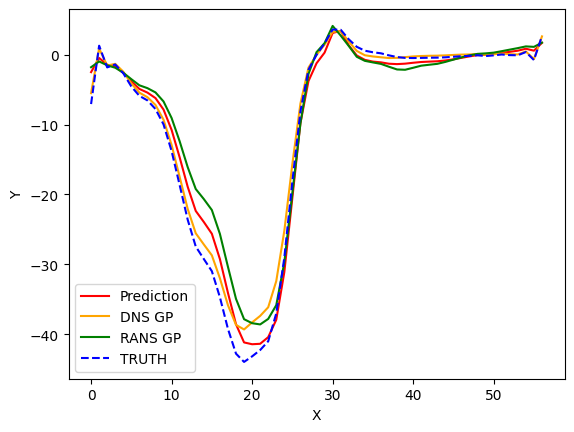

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
fig,ax=plt.subplots()
#DNS_test.shape[0]
i=0

#for i in range(1):
ax.plot(hf_mean_lin_mf_model[i],color='r',label='Prediction')
#ax.fill_between((hf_mean_lin_mf_model[0] - 1.96*hf_std_lin_mf_model[0]).flatten(), 
#(hf_mean_lin_mf_model[0] + 1.96*hf_std_lin_mf_model[0]).flatten(), color='r', alpha=0.3)
# ax.plot(RANS_test[:,i],color='k',linestyle='dotted',label='RANS')
ax.plot(hf_mean_high_gp_model[i],color='orange',label='DNS GP')
ax.plot(lf_mean_low_gp_model[i],color='green',label='RANS GP')
ax.plot(DNS_test[:,i],color='b',linestyle='--',label='TRUTH')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()


# np.savetxt('MF_70_e50_dns5_rans_8.dat', zip(write_mf), fmt=['%.3f','%.3f'])
# np.savetxt('LF_70_e50_dns5_rans_8.dat', zip(x_data,y_lf), fmt=['%.3f','%.3f'])
# np.savetxt('HF_70_e50_dns5_rans_8.dat', zip(x_data,y_hf), fmt=['%.3f','%.3f'])

In [ ]:
# CI = np.ones(c[1])*1.96*hf_std_lin_mf_model[i,:].reshape(-1,1)
# CI=CI.T
# print(CI.shape)
x_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/xshort_points.csv') 
y_data=hf_mean_lin_mf_model[i].reshape(-1,1)
y_hf=hf_mean_high_gp_model[i].reshape(-1,1)
y_lf=lf_mean_low_gp_model[i].reshape(-1,1)
print(y_data.shape)
print(x_data.shape)
write_mf = np.stack((x_data,y_data), axis = 1).reshape(-1,2)
write_lf = np.stack((x_data,y_lf), axis = 1).reshape(-1,2)
write_hf = np.stack((x_data,y_hf), axis = 1).reshape(-1,2)
print(write_hf.shape)

e= "streamwise WSS"
hdrtxt='# xpoints','#ypoints'
np.savetxt('/content/drive/MyDrive/ColabNotebooks/MF_60_e0_dns6_rans_20.dat', write_mf, delimiter='  ' )
np.savetxt('/content/drive/MyDrive/ColabNotebooks/LF_60_e0_dns6_rans_20.dat', write_lf, delimiter='   ' )
np.savetxt('/content/drive/MyDrive/ColabNotebooks/HF_60_e0_dns6_rans_20.dat', write_hf, delimiter='   ' )

In [ ]:
fig,ax=plt.subplots()
for i in range(hf_mean_lin_mf_model.shape[0]):
   ax.plot(hf_mean_lin_mf_model[i])
ax.set_xlabel('X')
ax.set_ylabel('Y')


In [ ]:
i=4
y_true=DNS_test[:,i].reshape(-1,1)
# y_rans=RANS_test[:,i].reshape(-1,1)


write_truth = np.stack((x_data,y_true), axis = 1).reshape(-1,2)
# write_rans = np.stack((x_data,y_rans), axis = 1).reshape(-1,2)


np.savetxt('/content/drive/MyDrive/ColabNotebooks/Truth_40_e30.dat', write_truth, delimiter='  ' )
# np.savetxt('/content/drive/MyDrive/ColabNotebooks/RANS_70_e50.dat', write_rans, delimiter='   ' )


In [ ]:
DNS_test=np.transpose(DNS_test)
fig,ax=plt.subplots()
for i in range(DNS_test.shape[1]):
   ax.plot(DNS_test[:,i])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.plot(hf_mean_lin_mf_model[2],color='r',linestyle='dotted',label='Prediction')


In [ ]:

fig,ax=plt.subplots()
for i in range(RANS_full.shape[1]):
   ax.plot(RANS_full[:,i])
ax.set_xlabel('X')
ax.set_ylabel('Y')

In [ ]:
  print(DNS_test[0])


In [ ]:
plt.figure(figsize=(12,8))
plt.ylabel('HF(x)')
plt.xlabel('LF(x)')

plt.plot(y_train_l[[0,2,4,7,8,10],:], y_train_h, color='purple',marker='*',)
plt.title('Mapping from low fidelity to high fidelity')
plt.legend(['HF-LF Correlation'], loc='lower center');

In [ ]:
print(Y_train)

In [ ]:
print(Y_train.shape)

In [ ]:

kernels = [GPy.kern.ExpQuad(input_dim=2,lengthscale=5.0,variance=0.0001),GPy.kern.ExpQuad(input_dim=2,lengthscale=5.0,variance=0.0001)]

lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)

gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2)

gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0)

#gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)
lin_mf_model =model=GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=500)

## Fit the model
  
lin_mf_model.optimize()